Produce an example network that features epistasis. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import defaultdict
from scipy.sparse import dok_matrix, csr_matrix
from sklearn.preprocessing import normalize
import networkx as nx
import itertools
from itertools import islice
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
import scipy as sp
import math
import csv
from collections import OrderedDict
import sys
import matplotlib.cm as cm
import matplotlib.colors as colors

L = 15
df = pd.read_csv("../../Titeseq/results/Kds/cleaned_Kds_RBD_ACE2.tsv",
                 dtype={"geno":"str"}, sep="\t")
df["geno_int"] = df.geno.apply(lambda x: int(x, 2))

df = df.set_index("geno_int").reindex(range(0, 2**L)).reset_index()
sequences_int = range(0,2**L)
for ii in range(L):
    df[f"mutation_{ii+1}"] = df.geno.str[ii] == '1'



mutation_names = ['G339D','S371L','S373P','S375F','K417N','N440K','G446S','S477N',
                  'T478K','E484A','Q493R','G496S','Q498R','N501Y','Y505H']

mdct = {m: i for i, m in enumerate(mutation_names)}

colors = ["#66c2bd", "#1b9d9b", "#fc7864", "#d94602", "#8DA0CB","#7570B3",
          "#E78AC3","#E7298A","#A6D854","#66A61E","#FFD92F","#E6AB02","#E5C494","#A6761D","#B3B3B3","#666666"]
fitness = (df[f"log10Kd"]).values.astype('float32')

In [3]:
k1 = 'Q493R'
k2 = 'Q498R'
k3 = 'N501Y'

def locus(x):
    return x[mdct[k1]] + x[mdct[k2]] + x[mdct[k3]]

dft = df.copy()
dft['locus'] = dft.geno.apply(locus)
dft['locus_effect'] = dft.geno.apply(lambda x: fitness[int(x,2)] - fitness[
    int(x[:mdct[k1]] + '0' +
    x[mdct[k1]+1: mdct[k2]] + '0' +
    x[mdct[k2]+1: mdct[k3]] +'0'+
    x[mdct[k3]+1:], 2)])
dft['nb_mut'] = dft.locus.str.count('1')

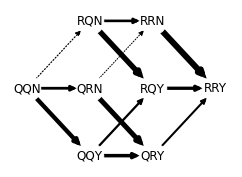

In [5]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def fixation_probability_moderate(fitness_s,fitness_t,Npop,gamma):
    if np.isnan(fitness_s) or np.isnan(fitness_t):
        pval = 0.0
    else:
        delta = fitness_t - fitness_s
        if delta == 0.0:
            pval = 1.0/Npop
        elif Npop*gamma*delta > -100:
            pval = ((1 - np.exp(-gamma*delta))/(1 - np.exp(-Npop*gamma*delta)))
        else:
            pval = 0
    return pval

G = nx.DiGraph()
G.add_nodes_from([a + b + c for a in '01' for b in '01' for c in '01'])

cma =  cm.get_cmap('YlGnBu', 12)

minlogkd=np.inf
for a in G.nodes:
    for b in G.nodes:
        if bin(int(a, 2)^int(b, 2)).count('1')== 1 and a.count('1') < b.count('1'):
            minlogkd = np.min((minlogkd, dft[dft.locus == b].log10Kd.mean() - dft[dft.locus == a].log10Kd.mean()))

for a in G.nodes:
    for b in G.nodes:
        if bin(int(a, 2)^int(b, 2)).count('1')== 1 and a.count('1') < b.count('1'):
            G.add_edge(a, b, 
                       weight = dft[dft.locus == b].log10Kd.mean() - dft[dft.locus == a].log10Kd.mean() - minlogkd
                       ,
                       colr = "k",
                       stle = "-" if dft[dft.locus == b].log10Kd.mean() > dft[dft.locus == a].log10Kd.mean() else "dotted")
#print([n for n in G])
dct = {}
posy = {}
for a in G.nodes:
    if a.count('1') not in dct:
        dct[a.count('1')] = 0
        posy[a] = 0
    else:
        dct[a.count('1')] += 1
        posy[a] = dct[a.count('1')]
        
for a in G.nodes:
    posy[a] -= dct[a.count('1')]/2

mut_names = [k1, k2, k3]
node_labels = {a: (k1[0] if a[0] == '0' else k1[-1])
               +(k2[0] if a[1] == '0' else k2[-1]) 
               +(k3[0] if a[2] == '0' else k3[-1]) for a in G.nodes}

with open("../Figures/data/example_epistasis.csv", "w") as fw:
    print("Source_node", "Target_node", "edge_weight", sep="\t", file=fw)
    for a, b in G.edges:
        print(node_labels[a], node_labels[b], G.edges[(a, b)]['weight'], sep="\t", file=fw)


fig, (ax, axb) = plt.subplots(1, 2, figsize=(9, 3))
nx.draw_networkx(G, pos={a:(a.count('1'), posy[a]) for a in G.nodes}, width=0,
                 with_labels=True, labels=node_labels,  node_size=700, node_color='w',
                 font_size=12, font_family='Helvetica', ax=ax)

nx.draw_networkx_edges(G, pos={a:(a.count('1'), posy[a]) for a in G.nodes}, 
                 width=[3*nx.get_edge_attributes(G, 'weight')[a] +1 for a in G.edges],
                 edge_color=[nx.get_edge_attributes(G, 'colr')[a] for a in G.edges],
                 style= [nx.get_edge_attributes(G, 'stle')[a] for a in G.edges],ax=ax,
                      arrows=True, arrowsize=10,node_size=700 )

ax.axis('off')

a = np.array([[0,1]])
img = axb.imshow(a, cmap=cma)
plt.gca().set_visible(False)

plt.savefig("/home/thomas/Downloads/web1.pdf", dpi=600)

